# Chapter 2.4 — Dropout and Normalization: Keeping Learning Stable

*How transformers stay efficient, prevent overfitting, and ensure consistent learning dynamics.*

Companion article: [Medium — Chapter 2.4](https://github.com/vadidshaikh/LLM-FROM-BASICS/blob/main/2_attention_is_all_you_need/2_4_dropout_and_normalization.ipynb)

Reference: Sebastian Raschka, *Build a Large Language Model (From Scratch)*

Purpose: Implement and visualize the two key stabilization techniques used throughout transformer architectures — **Dropout** and **Layer Normalization**.

## Why We Need Stability

Training transformers involves passing gradients through many layers of attention and feedforward blocks. Without regulation, the model might:
- Overfit to training data
- Produce unstable gradients
- Diverge during optimization

Dropout and normalization prevent these issues by controlling activations and maintaining consistent feature scales across layers.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(42)

## 1️⃣ Dropout — Preventing Overfitting

Dropout randomly zeroes out some neurons during training, forcing the model to learn more robust representations rather than memorizing exact patterns.

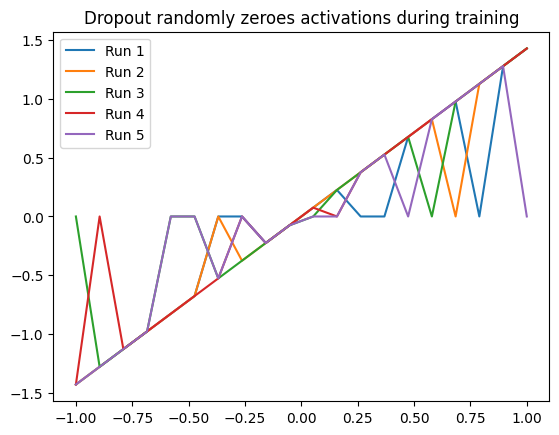

In [2]:
x = torch.linspace(-1, 1, 20)
dropout = nn.Dropout(p=0.3)

outputs = [dropout(x) for _ in range(5)]

for i, out in enumerate(outputs):
    plt.plot(x.numpy(), out.numpy(), label=f'Run {i+1}')

plt.title('Dropout randomly zeroes activations during training')
plt.legend()
plt.show()

When `p=0.3`, roughly 30% of neurons are turned off during each forward pass.

At inference time, dropout is **disabled**, and outputs are scaled automatically so the expected activation stays the same.

## 2️⃣ Layer Normalization — Keeping Inputs Balanced

Layer normalization ensures that the inputs to each layer have a stable mean and variance, preventing gradients from exploding or vanishing.

In transformers, LayerNorm is applied **before or after** sublayers (depending on architecture variant).

In [3]:
x = torch.randn(2, 5)
print('Before normalization:\n', x)

layer_norm = nn.LayerNorm(x.size()[1])
x_norm = layer_norm(x)

print('\nAfter normalization:\n', x_norm)

print('\nMean of each row after norm:', x_norm.mean(dim=1))
print('Std of each row after norm:', x_norm.std(dim=1))

Before normalization:
 tensor([[-0.6430,  0.7113,  0.4000, -1.2039, -0.4198],
        [-1.1929, -0.9351,  0.2138, -1.2842, -0.6917]])

After normalization:
 tensor([[-0.5899,  1.3496,  0.9037, -1.3932, -0.2702],
        [-0.7720, -0.2922,  1.8454, -0.9419,  0.1606]],
       grad_fn=<NativeLayerNormBackward0>)

Mean of each row after norm: tensor([-2.3842e-08, -2.3842e-08], grad_fn=<MeanBackward1>)
Std of each row after norm: tensor([1.1180, 1.1180], grad_fn=<StdBackward0>)


Each feature vector is normalized to have zero mean and unit variance — helping stabilize activations across deep stacks of layers.

## 3️⃣ Combining Both in a Transformer Block

Here’s a minimal example showing how dropout and normalization are used together inside a transformer sublayer.

In [4]:
class MiniTransformerBlock(nn.Module):
    def __init__(self, d_model, dropout_rate=0.1):
        super().__init__()
        self.linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout_rate)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        residual = x
        x = self.linear(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.norm(x + residual)
        return x

# Example
x = torch.rand(1, 4, 8)  # (batch, seq_len, d_model)
block = MiniTransformerBlock(d_model=8, dropout_rate=0.2)
out = block(x)
print('Output shape:', out.shape)

Output shape: torch.Size([1, 4, 8])


### Key Takeaways
- **Dropout**: adds noise during training to make learning robust.
- **Layer Normalization**: ensures consistent feature scales and stable gradients.
- Combined, they enable transformers to train deeper and generalize better.

**Next:** Chapter 3 — The Transformer Architecture: Putting Everything Together.